In [3]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

# nltk
import nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
df = pd.read_csv("/kaggle/input/cleaned-reddit-lemmatized/cleaned_reddit_lemmatized.csv")

## Simple Data Understanding

In [6]:
df.head(5)

,Unnamed: 0,subreddit,author,date,post,label,num_char,text_processed,mentioned_usernames,num_mentioned_usernames,...,mentioned_hashtags_cleaned,num_word,processed_num_word,num_mentioned_expressions,date_processed,date_day_of_week,date_month,date_year,date_hour,date_date
0,0,conspiracy,catvlyst,2018/12/17,My argument against the annunaki narrative One...,0,1249,my argument against the annunaki narrative one...,NaN,0,...,NaN,207,219,0,2018-12-17,0,12,2018,0,2018-12-17
1,1,conspiracy,When_The_Dank_Hits,2018/12/17,diagram of all involved in 911 is there a diag...,0,103,diagram of all involved in is there a diagram ...,NaN,0,...,NaN,20,17,0,2018-12-17,0,12,2018,0,2018-12-17
2,2,conspiracy,freethinker78,2018/12/17,Is the US government analyzing online comments...,0,1060,is the u government analyzing online comment a...,NaN,0,...,NaN,153,152,0,2018-12-17,0,12,2018,0,2018-12-17
3,3,conspiracy,MrBobosky,2018/12/17,Who owns the media? It’s clear that many compa...,0,709,who owns the medium it is clear that many comp...,NaN,0,...,NaN,124,134,0,2018-12-17,0,12,2018,0,2018-12-17
4,4,conspiracy,KodiakDog,2018/12/17,[Discussion] Top Secret Pharmaceuticals Does a...,0,1279,discussion top secret pharmaceutical doe anybo...,NaN,0,...,NaN,200,209,0,2018-12-17,0,12,2018,0,2018-12-17


In [7]:
df["subreddit"].unique()

array(['conspiracy', 'divorce', 'guns', 'fitness', 'jokes', 'legaladvice',
       'meditation', 'parenting', 'personalfinance', 'relationships',
       'teaching', 'addiction', 'adhd', 'alcoholism', 'anxiety', 'bpd',
       'bipolarreddit', 'autism', 'COVID19_support', 'depression',
       'EDAnonymous', 'healthanxiety', 'lonely', 'mentalhealth', 'ptsd',
       'schizophrenia', 'suicidewatch', 'socialanxiety'], dtype=object)

In [5]:
df = df[~df["subreddit"].isin(["mentalhealth", "COVID19_support"])]

In [11]:
print("number of 1 label: ", len(df[df["label"]==1]))
print("number of 0 label: ", len(df[df["label"]==0]))

number of 1 label:  426500
number of 0 label:  634489


In [6]:
df = df.groupby('subreddit', group_keys=False).apply(lambda x: x.sample(frac=0.6))

In [7]:
print("number of 1 label: ", len(df[df["label"]==1]))
print("number of 0 label: ", len(df[df["label"]==0]))

number of 1 label:  255902
number of 0 label:  380693


In [7]:
df['text_processed_trim'] = df['text_processed'].apply(lambda x: " ".join(str(x).split(" ")[:400]))

In [9]:
df.head()

,Unnamed: 0,subreddit,author,date,post,label,num_char,text_processed,mentioned_usernames,num_mentioned_usernames,...,num_word,processed_num_word,num_mentioned_expressions,date_processed,date_day_of_week,date_month,date_year,date_hour,date_date,text_processed_trim
913728,913728,EDAnonymous,kayteesays,2019/02/05,Antidepressants that don't cause weight gain? ...,1,531,antidepressant that do not cause weight gain h...,NaN,0,...,92,98,0,2019-02-05,1,2,2019,0,2019-02-05,antidepressant that do not cause weight gain h...
914040,914040,EDAnonymous,Venge22,2019/07/19,My binge-restrict cycle has transformed into a...,1,93,my binge restrict cycle ha transformed into a ...,NaN,0,...,15,18,0,2019-07-19,4,7,2019,0,2019-07-19,my binge restrict cycle ha transformed into a ...
913534,913534,EDAnonymous,remrem24,2019/07/08,Start treatment on Monday So the hospital prog...,1,306,start treatment on monday so the hospital prog...,NaN,0,...,57,65,0,2019-07-08,0,7,2019,0,2019-07-08,start treatment on monday so the hospital prog...
922173,922173,EDAnonymous,lemej,2019/02/24,Scaring yourself into eating more Background *...,1,2024,scaring yourself into eating more background 2...,NaN,0,...,353,372,0,2019-02-24,6,2,2019,0,2019-02-24,scaring yourself into eating more background 2...
911854,911854,EDAnonymous,morimaruko,2019/07/23,you guys they finally started selling those mo...,1,183,you guy they finally started selling those mon...,NaN,0,...,30,31,0,2019-07-23,1,7,2019,0,2019-07-23,you guy they finally started selling those mon...


In [8]:
df_new = df.sort_values(by='date', ascending=True)

In [9]:
df_new = df_new.reset_index()

## Prepare Training and Out of Sample Test Data

In [10]:
X_train = df_new[df_new["date_year"].isin([2018, 2019])]['text_processed_trim']
y_train = df_new[df_new["date_year"].isin([2018, 2019])]['label']
X_test = df_new[df_new["date_year"]==2020]['text_processed_trim']
y_test = df_new[df_new["date_year"]==2020]['label']

In [10]:
print("num training data: ", len(X_train))
print("num validation data: ", len(X_test))

num training data:  452856
num validation data:  183739


In [11]:
def get_tfidf_data(fit_data, transform_data_list, num_features, ngram_range):
    vectoriser = TfidfVectorizer(ngram_range=ngram_range, max_features=num_features)
    vectoriser.fit(fit_data)
    return list(map(vectoriser.transform, transform_data_list))

In [12]:
v1_map = {}
v1_map['X_train'], v1_map['X_test'] = get_tfidf_data(X_train, [X_train, X_test], 100000, (1, 3))

In [58]:
v1_map

{'X_train': <453258x100000 sparse matrix of type '<class 'numpy.float64'>'
 	with 96628075 stored elements in Compressed Sparse Row format>,
 'X_test': <183337x100000 sparse matrix of type '<class 'numpy.float64'>'
 	with 37664116 stored elements in Compressed Sparse Row format>}

## Model Training and Evaluation

In [13]:
def model_Evaluate(model, test_data):
    
    # Predict values for Test dataset
    y_pred = model.predict(test_data)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred, digits=4))
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    ax.set_title('Confusion Matrix \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [14]:
data_map = v1_map

              precision    recall  f1-score   support

           0     0.9142    0.9291    0.9216    109044
           1     0.8945    0.8733    0.8838     75038

    accuracy                         0.9064    184082
   macro avg     0.9043    0.9012    0.9027    184082
weighted avg     0.9062    0.9064    0.9062    184082



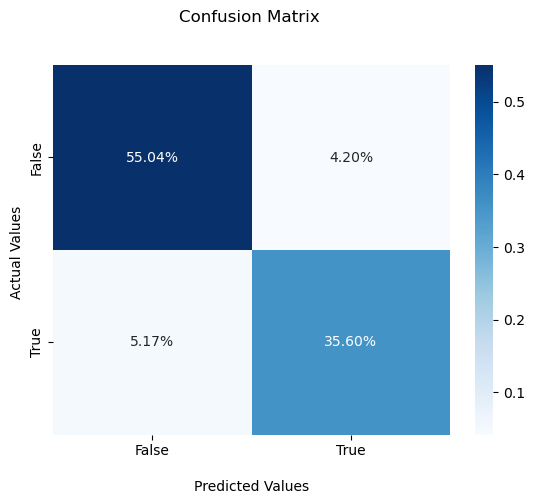

In [15]:
# naive bayes
BNBmodel = BernoulliNB()
BNBmodel.fit(data_map['X_train'], y_train)
model_Evaluate(BNBmodel, data_map['X_test'])

In [34]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('nb', BernoulliNB()),
])

In [52]:
parameters = {
    'tfidf__max_df': (0.8, 0.9),
    'tfidf__ngram_range': ((1, 1), (1, 2))
}

In [53]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=1, verbose=2)

grid_search = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=  32.5s
[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=  48.3s
[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time= 1.0min
[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time= 2.0min
[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time= 2.9min
[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time= 3.7min
[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=  31.7s
[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=  48.0s
[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time= 1.0min
[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time= 1.8min
[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time= 2.8min
[CV] END .......tfidf__max_df=0.9, tfidf__ngram_r

In [54]:
print(grid_search.best_params_)

{'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2)}


In [55]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, max_df=0.8)
X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

MNBmodel = BernoulliNB()
MNBmodel.fit(X_train_vec, y_train)

y_pred = MNBmodel.predict(X_test_vec)

precision = metrics.precision_score(y_test, y_pred, average="micro")
recall = metrics.recall_score(y_test, y_pred, average="micro")
f1 = metrics.f1_score(y_test, y_pred, average="micro")

print("Precison: {:.3f}".format(precision))
print("Recall:   {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))

Precison: 0.915
Recall:   0.915
F1 score: 0.915


              precision    recall  f1-score   support

           0       0.96      0.96      0.96    108751
           1       0.94      0.94      0.94     74586

    accuracy                           0.95    183337
   macro avg       0.95      0.95      0.95    183337
weighted avg       0.95      0.95      0.95    183337



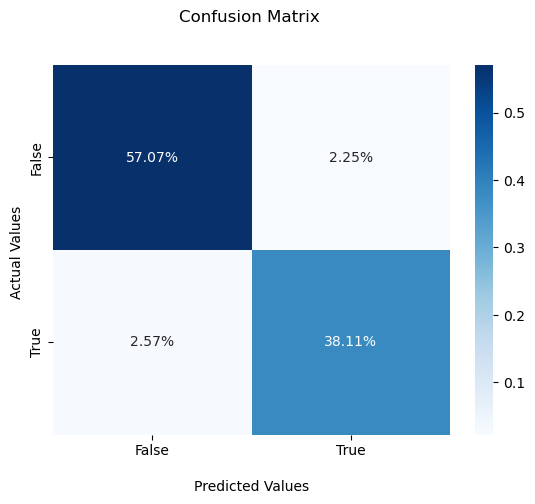

In [61]:
SVCmodel = LinearSVC()
SVCmodel.fit(data_map['X_train'], y_train)
model_Evaluate(SVCmodel, data_map['X_test'])

In [62]:
from sklearn.linear_model import LogisticRegression
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('lr', LogisticRegression()),
])

In [63]:
parameters_lr = {
    'tfidf__max_df': (0.8, 0.9),
    'tfidf__ngram_range': ((1, 1), (1, 2))
}

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
cv = TimeSeriesSplit(n_splits=3)
grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, n_jobs=1, verbose=2, cv=cv)

grid_search_lr = grid_search_lr.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=  43.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time= 1.6min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time= 2.4min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time= 3.7min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time= 4.8min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=  47.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time= 1.2min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time= 1.6min
[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time= 2.1min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time= 3.5min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .......tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time= 4.8min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [65]:
print(grid_search_lr.best_params_)

{'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2)}


In [14]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, max_df=0.8)
X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

LRmodel = LogisticRegression()
LRmodel.fit(X_train_vec, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [67]:
# save model pickle file
import pickle
pickle.dump(LRmodel, open("/kaggle/working/LRmodel.pkl", "wb"))

In [69]:
y_pred = LRmodel.predict(X_test_vec)

precision = metrics.precision_score(y_test, y_pred, average="micro")
recall = metrics.recall_score(y_test, y_pred, average="micro")
f1 = metrics.f1_score(y_test, y_pred, average="micro")

print("Precison: {:.3f}".format(precision))
print("Recall:   {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))

Precison: 0.953
Recall:   0.953
F1 score: 0.953


In [43]:
importance = LRmodel.coef_[0]
feature_names = vectoriser.get_feature_names()
data = {"feature_name": feature_names, "importance":list(importance)}
feature_importance = pd.DataFrame(data).sort_values("importance", ascending=False, key=abs)
feature_importance[:20]

,feature_name,importance
1600,adhd,21.069797
87895,tl dr,-19.652099
87894,tl,-19.516683
14206,bpd,18.774372
52443,meditation,-18.261012
7210,anxiety,18.075498
87896,tldr,-15.454723
52435,meditating,-14.684397
22028,depression,13.565427
9925,autism,12.914137


In [74]:
# posts with tldr
tldr_posts = df_new[(df_new["text_processed_trim"].str.contains("tldr") |df_new["text_processed_trim"].str.contains("tl dr") | df_new["text_processed_trim"].str.contains("tl") |df_new["text_processed_trim"].str.contains("dr"))]
tldr_posts.value_counts("subreddit")

subreddit
legaladvice        58313
personalfinance    42637
relationships      42173
depression         35382
anxiety            18696
suicidewatch       18385
adhd               15229
fitness            14434
parenting          11851
jokes               9660
bpd                 7547
conspiracy          6602
socialanxiety       6272
lonely              5502
guns                4603
meditation          4181
divorce             4153
EDAnonymous         3644
addiction           3134
ptsd                3107
alcoholism          3068
healthanxiety       2986
schizophrenia       2569
autism              2461
bipolarreddit       1995
teaching            1258
dtype: int64

## Model Explainability

In [44]:
import shap

In [45]:
# Fits the explainer
explainer = shap.Explainer(LRmodel, X_train_vec, feature_names=vectoriser.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [47]:
# take a sample of test data and calculate shap value
sample_test = X_test.reset_index(drop=True).sample(20)

In [48]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_vec[sample_test.index.values])

In [54]:
sample_test.index.values

array([139404,  98051, 165874, 109746, 132498,  60363,  63653,  26689,
       155208, 150742, 179233,  15226,   3768, 161614, 119565,  18353,
       110583,  51755,  75706,   2289])

In [63]:
df_new[df_new["index"]==452856]

,index,Unnamed: 0,subreddit,author,date,post,label,num_char,text_processed,mentioned_usernames,...,num_word,processed_num_word,num_mentioned_expressions,date_processed,date_day_of_week,date_month,date_year,date_hour,date_date,text_processed_trim
304813,452856,452856,personalfinance,wutevadude,2019/03/27,My first investment opportunity: too good to p...,0,2796,my first investment opportunity too good to pa...,NaN,...,500,508,0,2019-03-27,2,3,2019,0,2019-03-27,my first investment opportunity too good to pa...


In [66]:
sample_test.index.values[i]

139404

In [65]:
df_new[df_new["index"]==sample_test.index.values[i]]

,index,Unnamed: 0,subreddit,author,date,post,label,num_char,text_processed,mentioned_usernames,...,num_word,processed_num_word,num_mentioned_expressions,date_processed,date_day_of_week,date_month,date_year,date_hour,date_date,text_processed_trim


In [75]:
for i in range(30):
    if y_test.reset_index(drop=True)[sample_test.index.values[i]] == 1:
        print("index: ", i)
        print("post: ", sample_test.iloc[i])
        print("class: ", y_test.iloc[i])
        index_in_orginal_df = sample_test.index.values[i]
        print("index_in_orginal_df: ", index_in_orginal_df)
        print("sub-reddit: ", df_new.filter(items = [index_in_orginal_df], axis=0)["subreddit"].values)
        print("original post: ", df_new.filter(items = [index_in_orginal_df], axis=0)["post"].values)
        break

index:  0
post:  how can i stop being anxious about death so my family member died last year in november ever since i can not stop obsessing over and fearing death pretty much anything could trigger this fear in me for example my friend and i could make a long term plan and my mind will randomly think okay but will you be alive during that time and my day will automatically get ruined the fact that i believe in loa worsens the whole situation because i get anxious that whatever i invest too much thought into could actually manifest to reality these obsessive thought literally prevent me from enjoying life i want to learn how to stop btw i am year old if that matter in any way
class:  1
index_in_orginal_df:  139404
sub-reddit:  ['anxiety']
original post:  ["Panic attack I just recently had the worst panic attack I've ever had, it felt like I was having a heart attack. Its been three days since it happened, and it's had an effect on me. My heart rate has gotten faster, I feel weak/fatigu

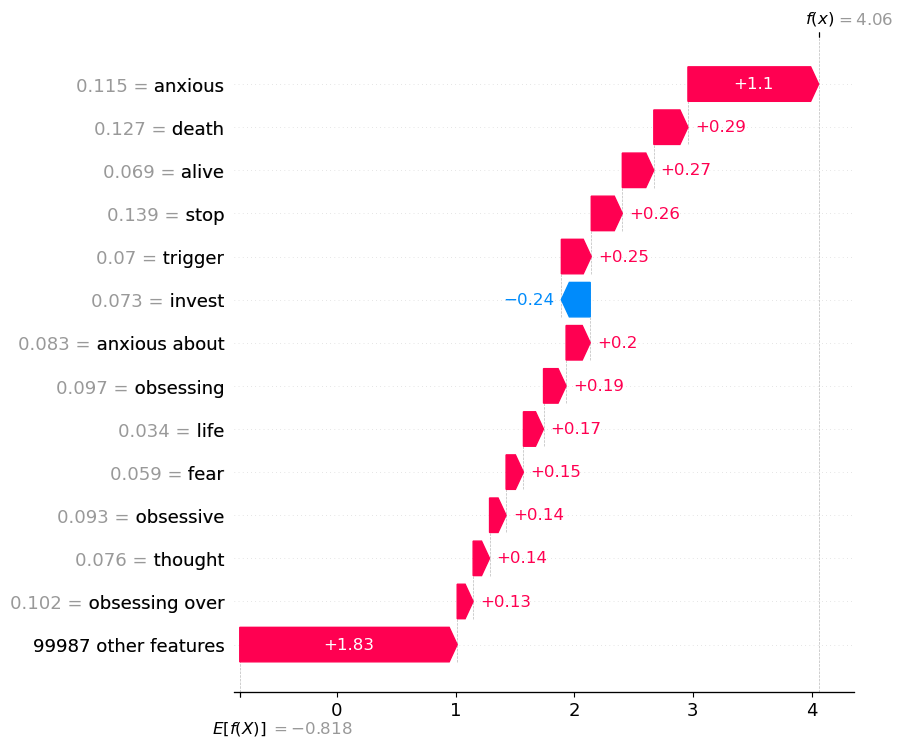

In [73]:
shap.plots.waterfall(shap_values[i], max_display=14)

In [ ]:
filename = "/kaggle/working/LRmodel.pkl"
loaded_model = pickle.load(open(filename, 'rb'))

              precision    recall  f1-score   support

           0     0.9278    0.9599    0.9436    109044
           1     0.9386    0.8915    0.9144     75038

    accuracy                         0.9320    184082
   macro avg     0.9332    0.9257    0.9290    184082
weighted avg     0.9322    0.9320    0.9317    184082



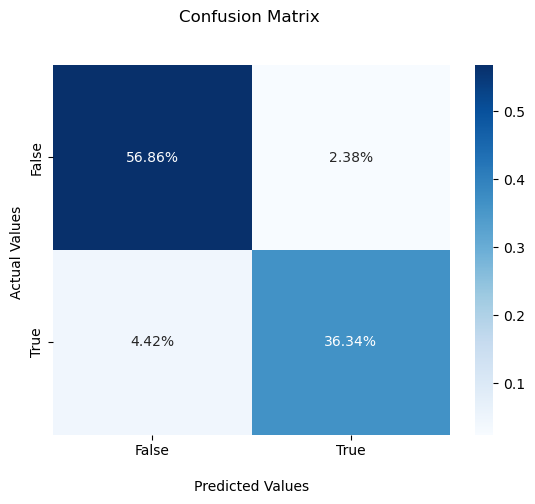

In [16]:
from xgboost import XGBClassifier
XGBmodel = XGBClassifier()
XGBmodel.fit(data_map['X_train'], y_train)
model_Evaluate(XGBmodel, data_map['X_test'])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(data_map['X_train'], y_train)
model_Evaluate(KNNmodel, data_map['X_test'])

              precision    recall  f1-score   support

           0       0.78      0.04      0.08    108751
           1       0.41      0.98      0.58     74586

    accuracy                           0.43    183337
   macro avg       0.59      0.51      0.33    183337
weighted avg       0.63      0.43      0.29    183337



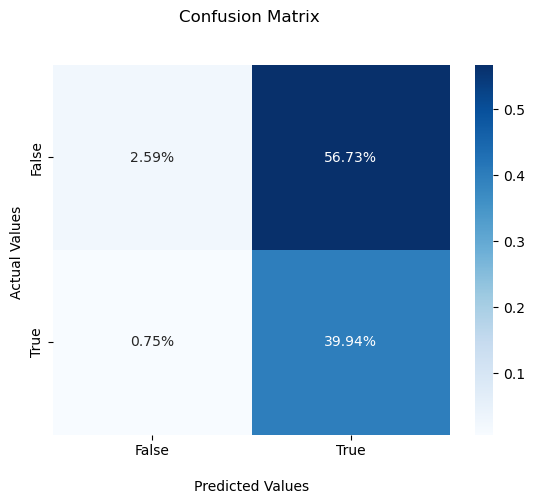

In [76]:
from sklearn.neighbors import KNeighborsClassifier
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(data_map['X_train'], y_train)
model_Evaluate(KNNmodel, data_map['X_test'])